<img src="./files/qsimov-logo.png" alt="Logo QSimov" align="right" width=300>


<h2><font color='#020e34' size=6>Neighborhood Quantum Superposition</font></h2>
<h2><font color='#020e34' size=5>Use Case: Solving MaxCut problem with QAOA</font></h2>
<html>
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
</html>

<br><br>
<div style="text-align: right">
<font color='#020e34' size=3>José Javier Paulet González</font><br>
<font color='#020e34' size=3>11/2023</font><br>
<font color='#020e34' size=3>QSimov Quantum Computing S.L.</font>

</div>

$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $

---

<h1><font color='#020e34' size=4>Environment Setup: Installing Libraries and Importing Functions</font></h1>

In [1]:
# Uncomment to install
#!pip install networkx qiskit qiskit-aer qsimov-cloud-client scipy pylatexenc

In [2]:
%run files/aux_func.py
from IPython.display import HTML
from qiskit import QuantumCircuit, Aer, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit.library import PhaseGate
from scipy.optimize import minimize


HTML('''<style>
        .output_png {
            display: table-cell;
            text-align: center;
            vertical-align: middle;
        }
        </style>''')

<h1><font color='#020e34' size=10>QAOA algorithm</font></h1>

The Quantum Approximate Optimization Algorithm (QAOA) is a hybrid quantum-classical optimization algorithm designed for solving combinatorial optimization problems that was introduced by Farhi et al. [1] . The objective is to determine the ideal parameters, denoted as $\beta_{opt}$ and $\gamma_{opt}$, in such a way that the quantum state $\ket{\psi(\beta_{opt},\gamma_{opt})}$ encodes the problem's optimal solution. The steps of the algorithm are:

1. Initialize parameters $\beta$ and $\gamma$.
2. Repeat until a convergence criteria is met:
  1. Compute the state $\underbrace{U_{\beta}(\beta_{p-1})\cdot U_{\gamma}(\gamma_{p-1})\ldots U_{\beta}(\beta_{0})\cdot U_{\gamma}(\gamma_{0})}_{p\ times}\ket{\psi_{0}}$ with the QAOA circuit.
  2. Measure the state $\ket{\psi(\beta,\gamma)}$ and compute $\bra{\psi(\beta,\gamma)}H_{p}\ket{\psi(\beta,\gamma)}$.
  3. Find new set of parameters $\beta_{new}$ and $\gamma_{new}$ using a classical optimization algorithm and update current parameters $\beta=\beta_{new}$ and $\gamma=\gamma_{new}$.

<img src="./files/QAOA.png" alt="QAOA algorithm" align="center">

The quantum part is a variational circuit that uses a unitary operator $U(\beta,\gamma)=U(\beta)\cdot U(\gamma)$ characterized by the parameters $\beta$ and $\gamma$ to prepare the quantum state:

\begin{equation}
\ket{\psi(\beta,\gamma)} = \underbrace{U_{\beta}(\beta_{p-1})\cdot U_{\gamma}(\gamma_{p-1})\ldots U_{\beta}(\beta_{0})\cdot U_{\gamma}(\gamma_{0})}_{p\ times}\ket{\psi_{0}}
\end{equation}

Where $\ket{\psi_{0}}$ is the initial state.



The quantum part consists of three primary components:
 - **Initial state operator**: QAOA begins by preparing an initial quantum state that serves as the starting point for the optimization process. This initial state is created with a superposition of all possible states using a set of Hadamard gates. It represents a uniform distribution over the solution space, which is crucial for the subsequent steps of the algorithm.
 - **Problem operator** $(U_{\gamma})$: This operator encodes the specific optimization problem into a quantum operator. This operator represents the objective function of the problem. QAOA involves adjusting the parameter of this operator to guide the quantum state toward optimal parameters $(\gamma_{opt})$. This operator can be defined as $U_{\gamma}=e^{-i\gamma H_{P}}$ where $H_{P}$ is the problem Hamiltonian.
 - **Mixing operator** $(U_{\beta})$: The mixing operator facilitate the exploration of the quantum state space. It encourages the quantum state to evolve and mix its amplitudes. This operator can be defined as $U_{\beta}=e^{-i\beta H_{B}}$ where $H_{B}$ is the mixing Hamiltonian.

<h1><font color='#020e34' size=10>MaxCut problem</font></h1>

The **MaxCut (Maximum Cut)** problem is a combinatorial optimization problem that involves partitioning a set of nodes into two disjoint sets in such a way that the sum of the cut edges is maximized. Formally, given an undirected graph **$G=(V,E)$** where **$V$** is a set of vertices and **$E$** is a set of edges, the objective is to find a partition of **$V$** into two subsets **$S$** and **$\overline{S}$** such that the sum of the edges crossing between **$S$** and **$\overline{S}$** is maximized.

<h1><font color='#020e34' size=6>Example</font></h1>

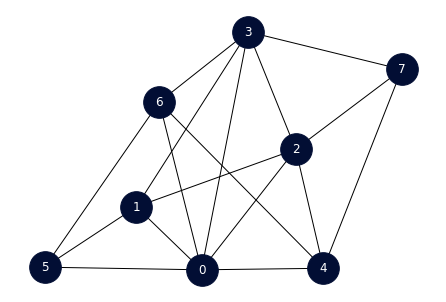

In [3]:
import networkx as nx

V = [0, 1, 2, 3, 4, 5, 6, 7]
E = {(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (1, 2), (1, 3), 
     (1, 5), (2, 3), (2, 4), (2, 7), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6)}

G = nx.Graph()
G.add_nodes_from(V)
G.add_edges_from(E)
nx.draw(G, with_labels=True, node_color='#020e34', node_size=1000, font_color='#ffffff')

<h1><font color='#020e34' size=4>Setting parameters</font></h1>

In [4]:
SEED = 0
N_SHOTS = len(V)
N_QUBITS = len(V)
tol = 10e-5

<h1><font color='#020e34' size=4>Initial state operator</font></h1>

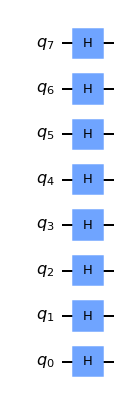

In [5]:
qc_0 = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_0.h(i)

qc_0.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Problem operator</font></h1>

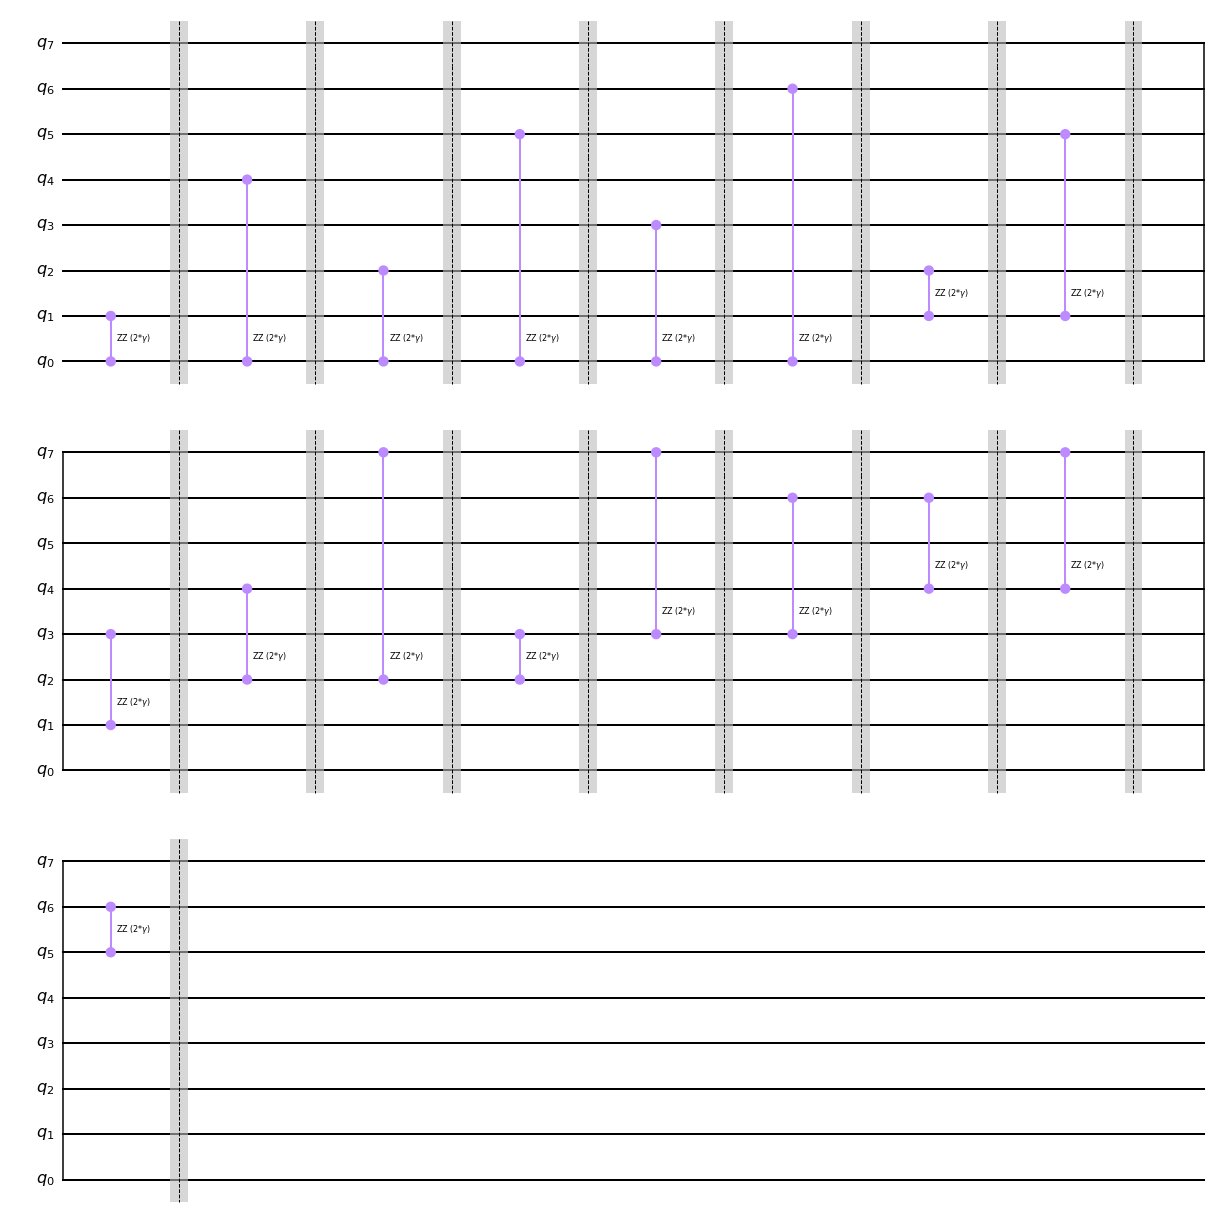

In [6]:
gamma = Parameter("$\\gamma$")
qc_p = QuantumCircuit(N_QUBITS)
for pair in list(G.edges()):  # pairs of nodes
    qc_p.rzz(2 * gamma, pair[0], pair[1])
    qc_p.barrier()

qc_p.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Mixing operator</font></h1>

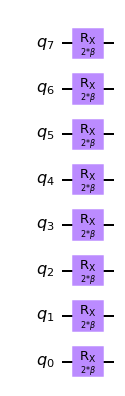

In [7]:
beta = Parameter("$\\beta$")
qc_mix = QuantumCircuit(N_QUBITS)
for i in range(N_QUBITS):
    qc_mix.rx(2 * beta, i)

qc_mix.draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Complete circuit</font></h1>

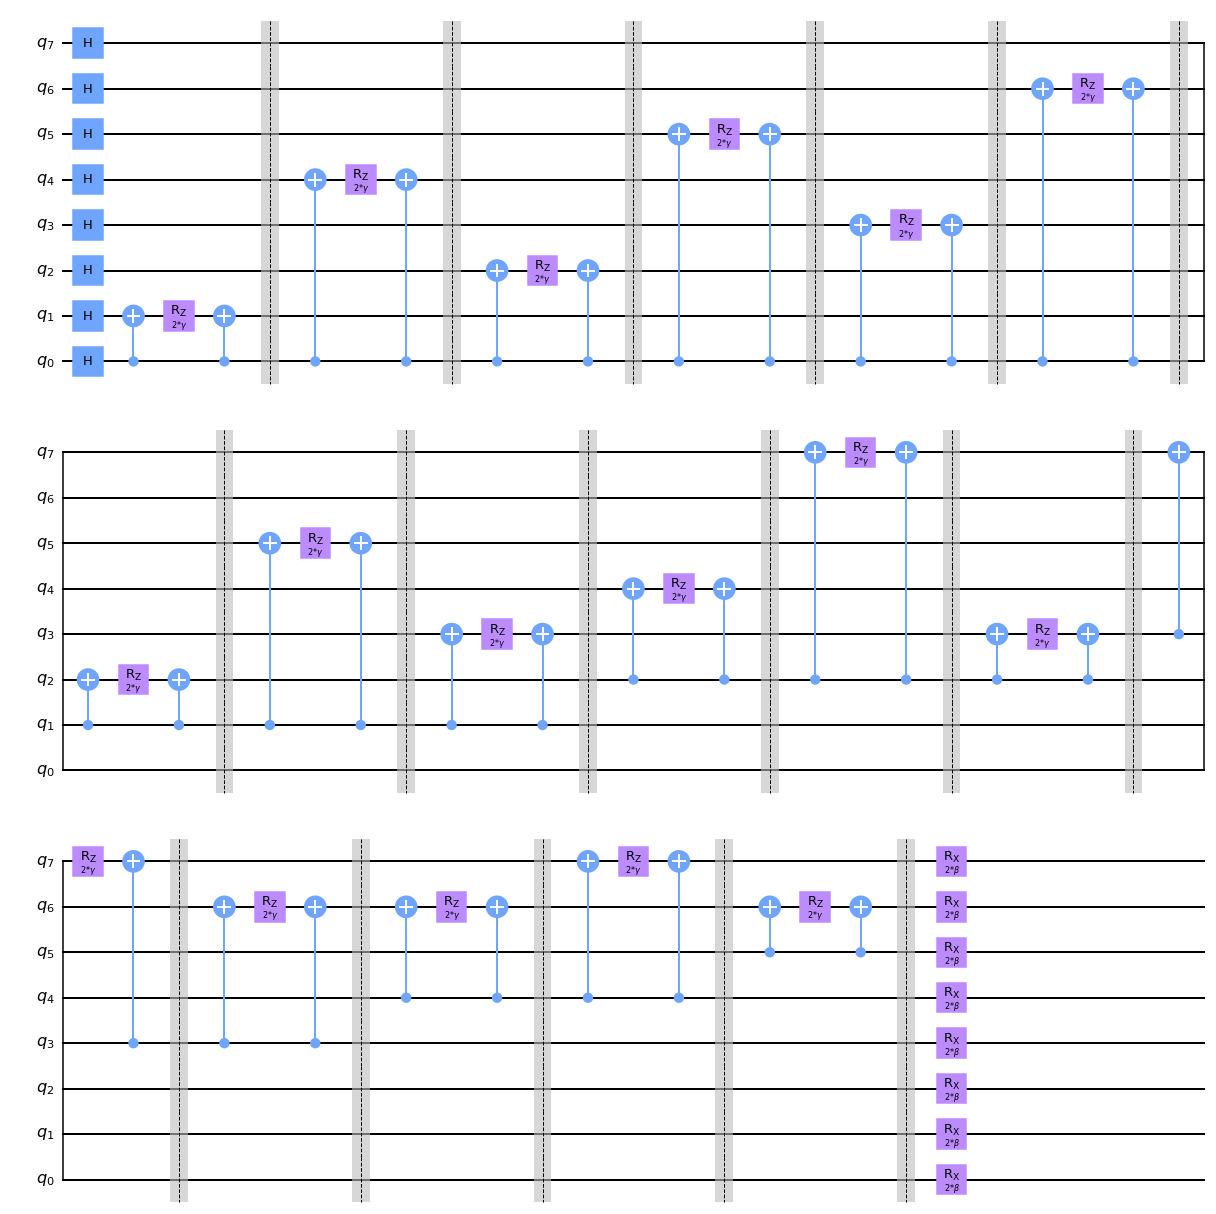

In [8]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(qc_0, range(N_QUBITS))
qc_qaoa.append(qc_p, range(N_QUBITS))
qc_qaoa.append(qc_mix, range(N_QUBITS))

qc_qaoa.decompose().decompose(gates_to_decompose=["rzz"]).draw(output='mpl', reverse_bits=True)

<h1><font color='#020e34' size=4>Functions for QAOA algorithms steps</font></h1>

In [9]:
# Cost function
def maxcut_obj(solution, G):
    """Given a bit string as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    Args:
        solution: (str) solution bit string
        G: networkx graph
    Returns:
        obj: (float) Objective
    """
    
    solution = solution[::-1]
    obj = 0
    for i, j in G.edges():
        if solution[i] != solution[j]:
            obj -= 1
    return obj

# Function to compute the expectation value
def compute_expectation(counts, G):
    """Computes expectation value based on measurement results
    Args:
        counts: (dict) key as bit string, val as count
        G: networkx graph
    Returns:
        avg: float
             expectation value
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, G)
        avg += obj * count
        sum_count += count
    return avg/sum_count


# Function to build the qaoa circuit
def create_qaoa_circ(G, theta, initial_state_operator=None):
    """Creates a parametrized qaoa circuit
    Args:
        graph: networkx graph
        theta: (list) unitary parameters
    Returns:
        (QuantumCircuit) qiskit circuit
    """
    nqubits = len(G.nodes())
    n_layers = len(theta)//2  # number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    # Initial state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # Problem operator
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # Mixer operator
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc


# Function that executes the circuit
def get_expectation(G, shots=N_SHOTS):
    """Runs parametrized circuit
    Args:
        G: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')

    def execute_circ(theta):
        qc = create_qaoa_circ(G, theta)
        counts = backend.run(qc, seed_simulator=SEED,
                             nshots=N_SHOTS).result().get_counts()
        return compute_expectation(counts, G)

    return execute_circ

# Function to see the process of QAOA algorithm
def callback_function(expectation):
    
    def callback(X):
        global n_eval
        print('{0:4d}   {1: 3.19f}   {2: 3.19f}   {3: 3.19f}'.format(n_eval, X[0], X[1], expectation(X)))
        n_eval += 1
    return callback

<h1><font color='#020e34' size=4>Exhaustive Search for Optimal Solution</font></h1>

In [10]:
# Get the optumal solution by classical brute force
best_solution, max_val = solve_by_brute_force(N_QUBITS, maxcut_obj, G)

print("Best solution is: ", best_solution, max_val)

Best solution is:  00111100 -13


<h1><font color='#020e34' size=4>Results and Algorithm Execution</font></h1>

In [11]:
n_eval = 1

print('{0:4s}   {1:19s}   {2:21s}   {3:21s}'.format('Iter', ' β', ' γ', 'f(X)'))

expectation = get_expectation(G, N_SHOTS)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA',
               callback=callback_function(expectation),
               tol=tol,
               options={'disp': True})

Iter    β                     γ                      f(X)                 
   1    2.0000000000000000000    1.0000000000000000000   -8.3798828125000000000
   2    1.0000000000000000000    2.0000000000000000000   -8.5537109375000000000
   3    0.0023082574778608977    0.9320942793047758412   -8.4560546875000000000
   4    0.5011541287389305044    0.9660471396523879761   -8.4101562500000000000
   5    1.2497960306482607251    0.9899033137924772019   -8.5693359375000000000
   6    1.2447476875444993816    0.8650052984683468393   -8.4970703125000000000
   7    1.2649530363447807346    1.2394434211466172080   -8.5771484375000000000
   8    1.3138162974235862990    1.3544972421033523169   -8.3906250000000000000
   9    1.1402379668271600544    1.2478785521601236663   -8.5029296875000000000
  10    1.2806268212534932527    1.1789406735508640711   -8.6181640625000000000
  11    1.3258589049967741680    1.1358093786451830542   -8.5781250000000000000
  12    1.2268525022396148394    1.1470883170

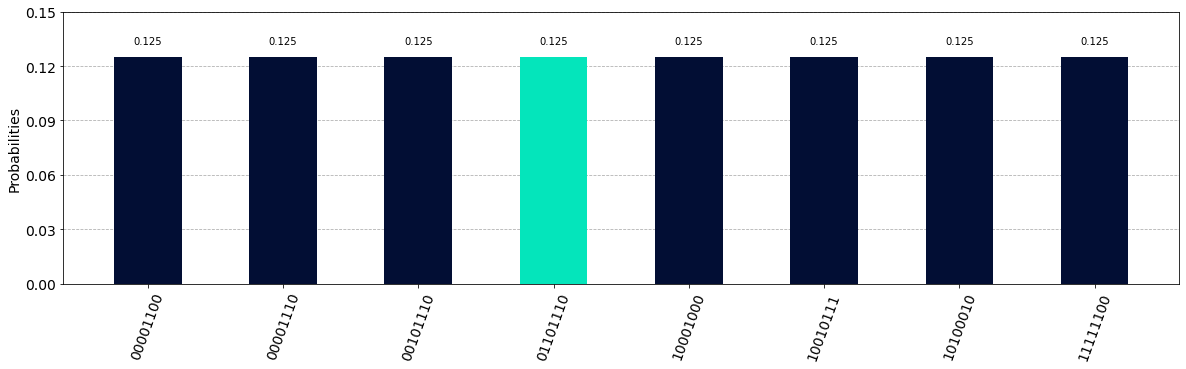

Solution state is: 01101110(110) with value -9


In [12]:
backend = Aer.get_backend('aer_simulator')

qc_res = create_qaoa_circ(G, res.x)
counts = backend.run(qc_res, seed_simulator=SEED, shots=N_SHOTS).result().get_counts()

# Calculate the best state
solution = get_best_solution(counts, maxcut_obj, G)

# Show histogram results
display(histogram_with_marked_solution(counts, solution))

print("Solution state is: {bin_state}({dec_state}) with value {value}".format(bin_state=solution, dec_state=int(solution, 2), value=maxcut_obj(solution, G)))

The solution graph is:


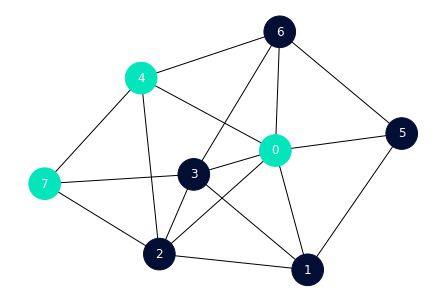

In [13]:
print("The solution graph is:")
values = ['#020e34' if bit == '1' else '#04e5bb' for bit in solution]
nx.draw(G, node_color=values[::-1], with_labels=True, alpha=1, node_size=1000, font_color='#FFFFFF')

<h1><font color='#020e34' size=4>Neighborhood Quantum Superposition approach</font></h1>

Next, we will solve the problem by reducing the number of states in the problem domain using **Neighborhood Quantum Superposition**. To achieve this, we need to modify the **Initial State Operator** of the **QAOA** algorithm and replace the **Hadamard** gates with the operator obtained through **Neighborhood Quantum Superposition**. Additionally, we will also need to modify the **Mixing Operator** to preserve the subspace of generated states. We will be guided by the GM-QAOA version proposed by Bartschi et al. [3].

To generate the initial superposition, we need to determine which subset of all possible states we want. To do this, we require a **reference state** from which to generate the neighborhood, the **metric** used to generate the neighborhood, and the **distances** of the states we want to superpose.

In our case, to determine which state we want as a reference, we will calculate it using a basic heuristic that involves splitting the nodes into two sets based on their degree, with one set having the highest degree nodes and the other set having the lowest degree nodes. Note that the heuristic is a parameter to investigate and will have a significant impact on the improvement we can achieve in solving the problem. For our case, we have chosen a simple and fast heuristic. We also can use **Quantum annealing** as heuristic to get a **reference state** as we can see in [4].

From the available metrics, including **Hamming** distance, **Ample** similarity, **Cosine** similarity, **Simpson** similarity, **Johnson** similarity, **Pearson I** similarity, **Jaccard** similarity, **Dice** similarity, **Tanimoto** similarity, we have chosen the **Hamming** distance.

For the distances of the states we want to superpose, we will choose distances between **1** and **3**, both inclusive, as we want to search for a solution near the state we calculated with the heuristic.

<img src="./files/GM-QAOA.png" alt="GM-QAOA algorithm" align="center">

In [14]:
# Calculate the 2 sets and the reference state
degrees = [(i, G.degree[i]) for i in range(len(V))]
sorted_degrees = sorted(degrees, key=(lambda x: x[1]), reverse=True)
high_degree_nodes = sorted_degrees[:len(sorted_degrees)//2]
low_degree_nodes = sorted_degrees[len(sorted_degrees)//2:]

states_in_set_0 = [node for node, value in high_degree_nodes]
states_in_set_1 = [node for node, value in low_degree_nodes]

starting_state = "".join(['0' if i in states_in_set_0 else '1' for i in range(len(V))[::-1]])
print(high_degree_nodes, low_degree_nodes)
print("Reference state: ", starting_state)

[(0, 6), (2, 5), (3, 5), (1, 4)] [(4, 4), (6, 4), (5, 3), (7, 3)]
Reference state:  11110000


In [15]:
from qsimov_cloud_client import QsimovCloudClient

# Initialize QsimovCloudClient with your access token
client = QsimovCloudClient('YOUR_API_TOKEN')

# Set parameters for the service
client.set_metric("hamming")
client.set_state(state_bin=starting_state)
client.can_have_nan(False)
client.set_ancilla_mode("clean")

# Choose a range for the superposition (both included)
range_metric = ('1', '3')
client.set_range(range_metric)

# Generate a quantum circuit (comment the next line if you don't)
circuit_superposition = client.generate_circuit()

# If you don't have an API token to make the request to the service,
# what are you waiting for? Obtain one and replace 'YOUR_API_TOKEN'.
# Until you get it, uncomment the following line to proceed with the notebook execution.

#circuit_superposition = superposition_circuit_hamming

In [16]:
# Access the result
print("Number of extra qubits", circuit_superposition.get_extra_qubits())
print("Number of superposed states", circuit_superposition.get_num_superposed())
print("The resulting circuit in qasm is:\n", circuit_superposition.get_qasm_code()[:1000])

Number of extra qubits 4
Number of superposed states 92
The resulting circuit in qasm is:
 OPENQASM 2.0;
include "qelib1.inc";
gate gate__gate q0,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11 { u3(1.9493373956565034,pi/16,-pi) q0; cx q0,q8; u3(0,0,-pi/16) q8; cx q0,q8; u3(0,0,pi/16) q8; u3(0,0,pi/16) q0; cx q0,q9; u3(0,0,-pi/16) q9; cx q0,q9; u3(0,0,pi/16) q9; ccx q0,q8,q9; u3(0,0,-pi/16) q0; cx q0,q9; u3(0,0,pi/16) q9; cx q0,q9; u3(0,0,-pi/16) q9; ccx q0,q8,q9; u3(0,0,pi/16) q0; cx q0,q10; u3(0,0,-pi/16) q10; cx q0,q10; u3(0,0,pi/16) q10; ccx q0,q9,q10; u3(0,0,-pi/16) q0; cx q0,q10; u3(0,0,pi/16) q10; cx q0,q10; u3(0,0,-pi/16) q10; ccx q0,q8,q10; u3(0,0,pi/16) q0; cx q0,q10; u3(0,0,-pi/16) q10; cx q0,q10; u3(0,0,pi/16) q10; ccx q0,q9,q10; u3(0,0,-pi/16) q0; cx q0,q10; u3(0,0,pi/16) q10; cx q0,q10; u3(0,0,-pi/16) q10; ccx q0,q8,q10; u3(0,pi/4,pi/4) q0; u3(0,0,pi/2) q11; cx q0,q11; u3(-pi/4,0,-pi/2) q11; cx q0,q11; u3(pi/4,0,0) q11; u3(0,0,pi/16) q0; cx q0,q11; u3(0,0,-pi/16) q11; cx q0,q11; u3(0,

<h1><font color='#020e34' size=4>New functions for GM-QAOA algorithm steps</font></h1>

In [17]:
def create_gm_qaoa_circ(G, theta, circuit_superposition):
    # Number of qubits needed
    n_main_qubits = len(G.nodes())
    n_ancilla_qubits = circuit_superposition.get_extra_qubits() # Get the number of extra qubits from response

    # Number of layers, in this case only 1
    n_layers = 1#len(theta)//2  # number of alternating unitaries

    # Create the new QAOA circuit
    q_reg = QuantumRegister(n_main_qubits + n_ancilla_qubits)
    c_reg = ClassicalRegister(n_main_qubits)
    qc_qaoa_modified = QuantumCircuit(q_reg, c_reg)
    
    # Gamma and Beta params
    gamma = theta[1]
    beta = theta[0]

    # The new hamming initial state from Neighborhood Quantum Superposition data
    
    initial_state_operator = QuantumCircuit.from_qasm_str(circuit_superposition.get_qasm_code()).decompose()
    initial_state_operator.name = "Initial state"
    qc_qaoa_modified.compose(initial_state_operator, inplace=True, wrap=True)

    # For each layer
    for layer_index in range(n_layers):

        # Problem operator
        for pair in list(G.edges()):
            qc_qaoa_modified.rzz(2 * gamma, pair[0], pair[1])

        # Mixer operator based on [3]
        qc_qaoa_modified.compose(initial_state_operator.inverse(), inplace=True, wrap=True)
        qc_qaoa_modified.x(range(n_main_qubits))

        z_parametrized_gate = PhaseGate(-beta)
        z_parametrized_gate_controlled = z_parametrized_gate.control(n_main_qubits - 1)

        qc_qaoa_modified.compose(z_parametrized_gate_controlled, [i - 1 for i in range(n_main_qubits, 0, -1)], inplace=True)

        qc_qaoa_modified.x(range(n_main_qubits))
        qc_qaoa_modified.compose(initial_state_operator, inplace=True, wrap=True)

    # Measure main qubits
    qc_qaoa_modified.measure(q_reg[:n_main_qubits], c_reg[:])
    
    return qc_qaoa_modified

def get_expectation_gm(G, shots=N_SHOTS, circuit_superposition=None):
    """Runs parametrized circuit
    Args:
        G: networkx graph
    """
    backend = Aer.get_backend('qasm_simulator')

    def execute_circ(theta):
        qc = create_gm_qaoa_circ(G, theta, circuit_superposition).decompose()
        counts = backend.run(qc, seed_simulator=SEED,
                             nshots=N_SHOTS).result().get_counts()
        
        return compute_expectation(counts, G)

    return execute_circ

<h1><font color='#020e34' size=4>Complete circuit</font></h1>

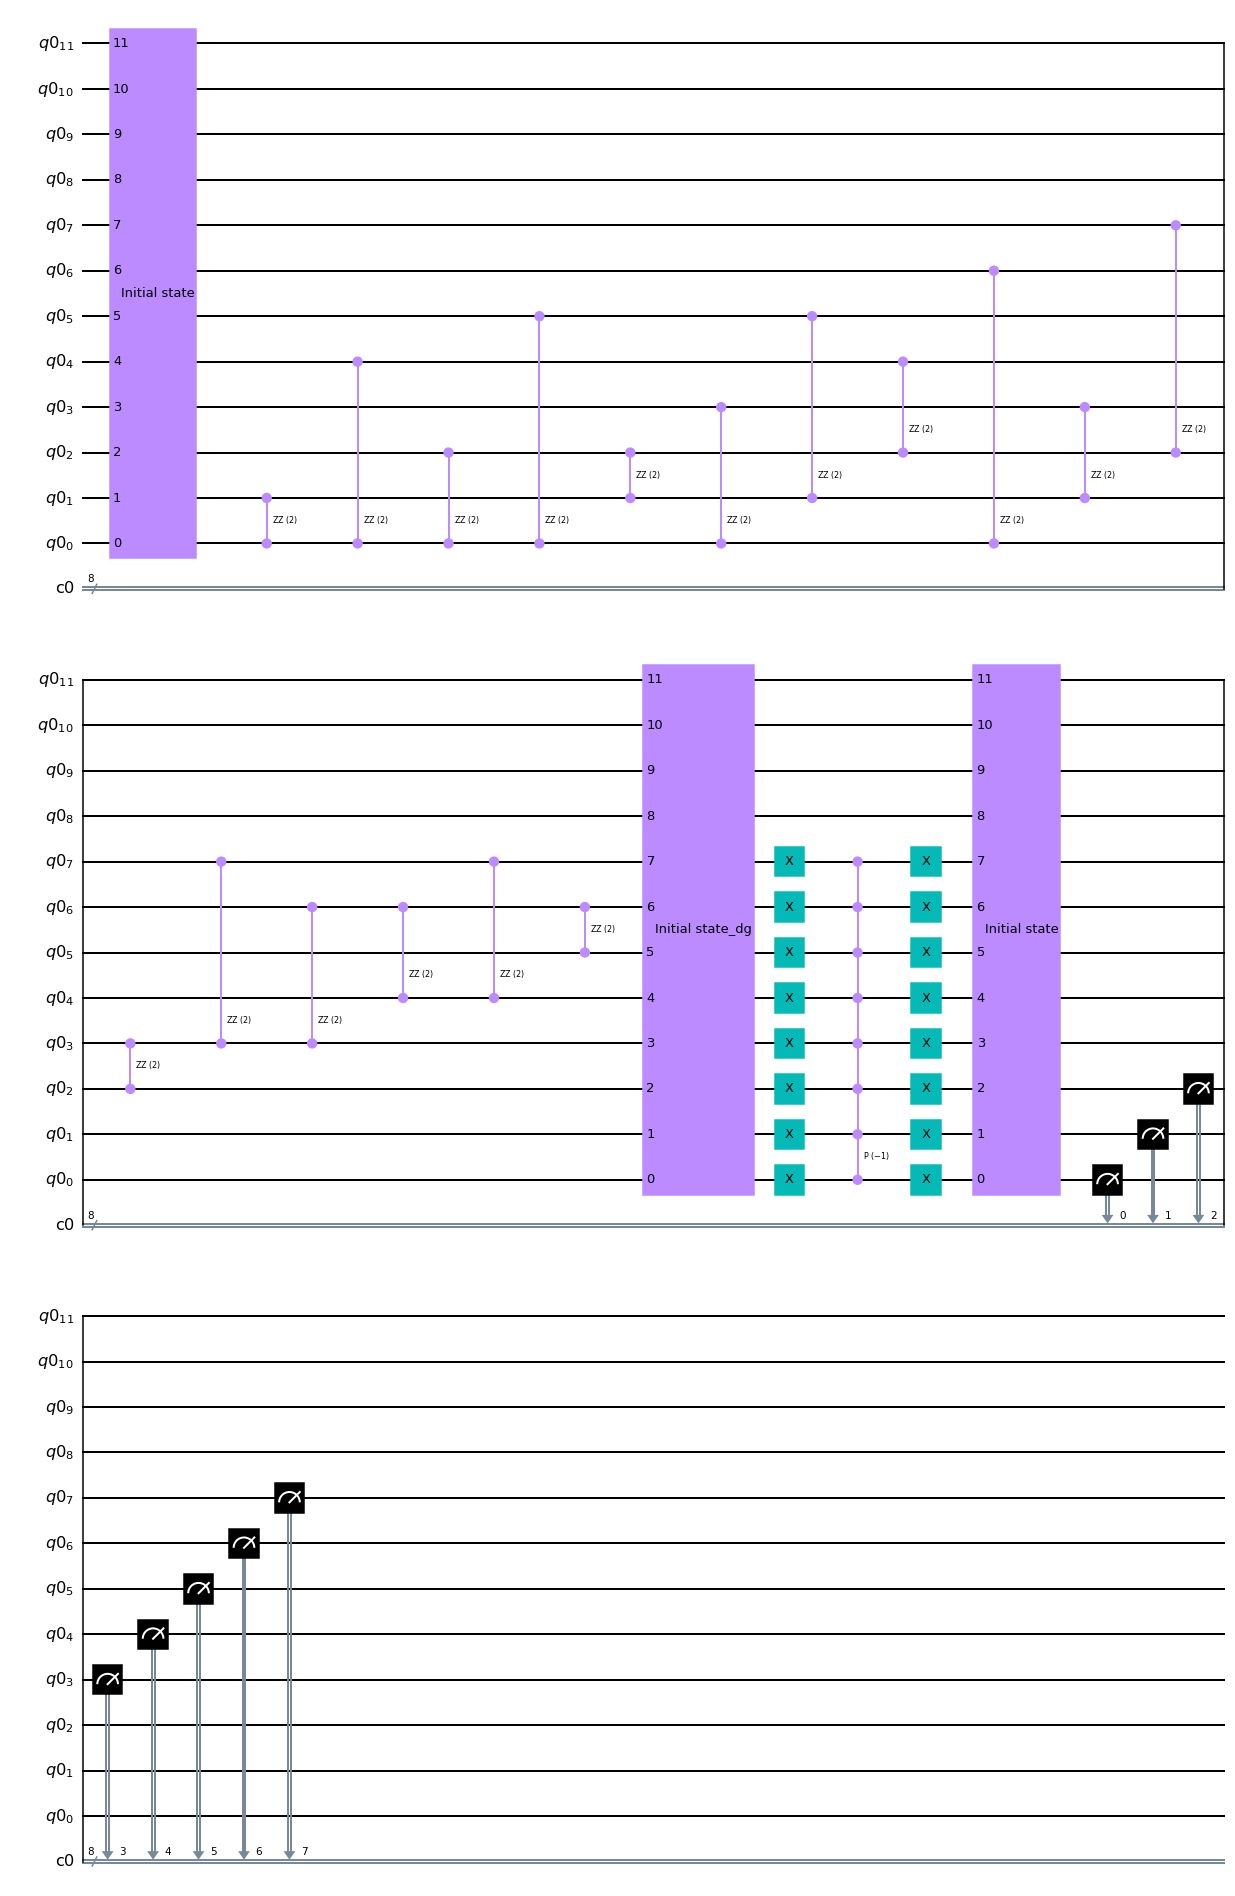

In [18]:
display(create_gm_qaoa_circ(G, [1, 1], circuit_superposition).draw(output='mpl', reverse_bits=True))

<h1><font color='#020e34' size=4>Results and Algorithm Execution</font></h1>

In [19]:
n_eval = 1
    
print('{0:4s}   {1:19s}   {2:21s}   {3:21s}'.format('Iter', ' β', ' γ', 'f(X)'))

expectation_hamming = get_expectation_gm(G, N_SHOTS, circuit_superposition)
res_hamming = minimize(expectation_hamming,
               [1.0, 1.0],
               method='COBYLA',
               callback=callback_function(expectation_hamming),
               tol=tol,
               options={'disp': True})

Iter    β                     γ                      f(X)                 
   1    2.0000000000000000000    1.0000000000000000000   -8.4804687500000000000
   2    2.0000000000000000000    2.0000000000000000000   -8.5751953125000000000
   3    2.2864415830283810749    2.9580977087501021394   -8.9091796875000000000
   4    3.2802766092080459792    3.0689667339034998328   -8.1894531250000000000
   5    1.4828130141758624205    3.5532288903597137875   -7.7441406250000000000
   6    2.7858259276802366244    2.9332929447593549810   -7.8964843750000000000
   7    2.1833688341620942630    2.7303346554663279200   -8.1416015625000000000
   8    2.1869291680773867981    3.1874386760250770223   -7.9248046875000000000
   9    2.4111969196087446043    2.9502806764027091901   -8.5830078125000000000
  10    2.2572670270558572447    3.0133706251179406266   -9.2060546875000000000
  11    2.2262856966417148286    3.0676514427773100557   -9.0742187500000000000
  12    2.2296305688719377791    2.9987833471

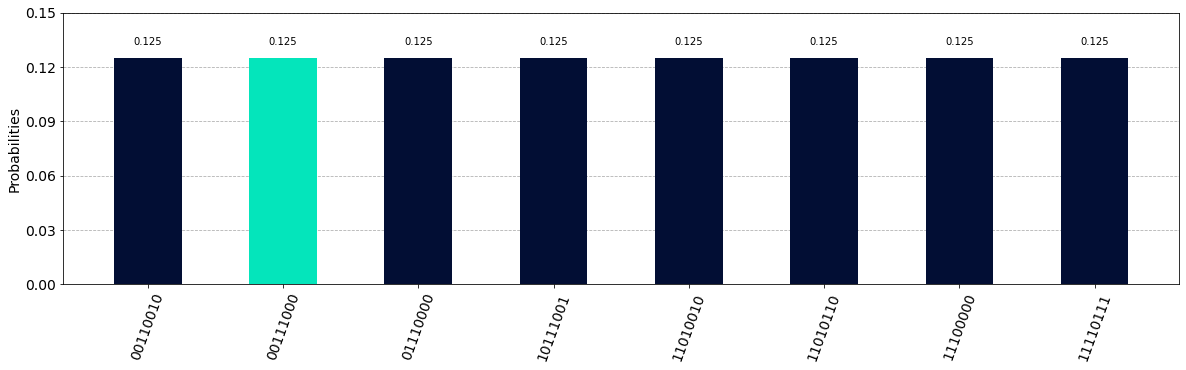

Solution state is: 00111000(56) with value -12


In [20]:
qc_res = create_gm_qaoa_circ(G, res_hamming.x, circuit_superposition).decompose()
counts_hamming = backend.run(qc_res, seed_simulator=SEED, shots=N_SHOTS).result().get_counts()

solution_hamming = get_best_solution(counts_hamming, maxcut_obj, G)

display(histogram_with_marked_solution(counts_hamming, solution_hamming))

print("Solution state is: {bin_state}({dec_state}) with value {value}".format(bin_state=solution_hamming, dec_state=int(solution_hamming, 2), value=maxcut_obj(solution_hamming, G)))

The solution graph is:


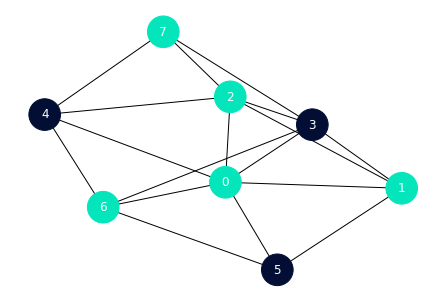

In [21]:
print("The solution graph is:")
values_hamming = ['#020e34' if bit == '1' else '#04e5bb' for bit in solution_hamming]
nx.draw(G, node_color=values_hamming[::-1], with_labels=True, alpha=1, node_size=1000, font_color='#FFFFFF')

# Results and Implications

The results speak for themselves. With **Neighborhood Quantum Superposition**, the **MaxCut problem** is solved with increased efficiency. Fewer iterations are required, leading to faster convergence, and the algorithm consistently reaches better solutions.

This is a very simple use case, the parts of the algorithm where one can investigate and reduce the algorithm's complexity are:

- Number of **layers** of the algorithm.
- Number of **shots**.
- The **metric** used.
- The **problem domain size**.
- The **mixing operator**.
- The **heuristic** for the reference state.

# References

[1] Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. ["A quantum approximate optimization algorithm"][qaoa]. *arXiv preprint* arXiv:1411.4028 (2014). 

[2] Qiskit Community Tutorials. ["Solving Combinatorial Optimization Problems using QAOA"][qaoa-tutorial].

[3] Bartschi, A., & Eidenbenz, S. (2020, October). ["Grover Mixers for QAOA: Shifting Complexity from Mixer Design to State Preparation"][gm-qaoa]. In 2020 IEEE International Conference on Quantum Computing and Engineering (QCE) (pp. 1-10). IEEE. DOI: 10.1109/qce49297.2020.00020 

[4] Paulet, J. J., LLana, L. F., de la Cruz, H. I., Mezzini, M., Cuartero, F., & Pelayo, F. L. (2023). ["A hybrid Quantum proposal to deal with 3-SAT problem"][annealing-circuits]. arXiv preprint arXiv:2306.04378.


[qaoa]: https://arxiv.org/abs/1411.4028
[qaoa-tutorial]: https://learn.qiskit.org/course/ch-applications/solving-combinatorial-optimization-problems-using-qaoa
[gm-qaoa]: https://arxiv.org/abs/2006.00354
[annealing-circuits]: https://arxiv.org/abs/2306.04378